<a href="https://www.kaggle.com/code/danuherath/mental-health-data-binary-classification?scriptVersionId=218267015" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

<h1 align="center">Exploring Mental Health Data (Binary Classification)</h1>

<img
    src="https://www.kaggle.com/competitions/84895/images/header"
    alt=""
    width="300"
    height="200"
    style="display: block; margin: 0 auto; border-radius:15px"
/>

---

## Problem Definition

- Domain
    
    - Psychology | Healthcare

<br>

- Dataset

    - [Exploring Mental Health Data](https://www.kaggle.com/competitions/playground-series-s4e11/data) dataset from Kaggle which contains 17 features explaining an individaul's demographics, professional and educational background and other stress related health habits. Train dataset contains 140,700 samples and each instance represents one person.

<br>

- Objective

    - The goal of this project is to explore factors that may cause individuals to experience depression.

<br>

- Algorithms

    - Following classification algorithms are used to train models on the train dataset. The models are evaluated using the [Accuracy Score](https://scikit-learn.org/dev/modules/generated/sklearn.metrics.accuracy_score.html) metric.

        1. [XGBoost (Extreme Gradient Boosting) Classifier](https://xgboost.readthedocs.io/en/stable/python/python_api.html#xgboost.XGBClassifier)
        2. [LightGBM Classifier](https://lightgbm.readthedocs.io/en/latest/pythonapi/lightgbm.LGBMClassifier.html)
        3. [CatBoost Classifier](https://catboost.ai/en/docs/concepts/python-reference_catboostclassifier)

<br>


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.graphics.mosaicplot import mosaic
%config InlineBackend.figure_format="svg"

from sklearn.preprocessing import StandardScaler, OneHotEncoder, LabelEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split

from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier

from sklearn.metrics import accuracy_score

import optuna

RSEED = 42

In [2]:
train_data = pd.read_csv("/kaggle/input/playground-series-s4e11/train.csv")
test_data = pd.read_csv("/kaggle/input/playground-series-s4e11/test.csv")


In [3]:
train_data.head()


,id,Name,Gender,Age,City,Working Professional or Student,Profession,Academic Pressure,Work Pressure,CGPA,Study Satisfaction,Job Satisfaction,Sleep Duration,Dietary Habits,Degree,Have you ever had suicidal thoughts ?,Work/Study Hours,Financial Stress,Family History of Mental Illness,Depression
0,0,Aaradhya,Female,49.0,Ludhiana,Working Professional,Chef,NaN,5.0,NaN,NaN,2.0,More than 8 hours,Healthy,BHM,No,1.0,2.0,No,0
1,1,Vivan,Male,26.0,Varanasi,Working Professional,Teacher,NaN,4.0,NaN,NaN,3.0,Less than 5 hours,Unhealthy,LLB,Yes,7.0,3.0,No,1
2,2,Yuvraj,Male,33.0,Visakhapatnam,Student,NaN,5.0,NaN,8.97,2.0,NaN,5-6 hours,Healthy,B.Pharm,Yes,3.0,1.0,No,1
3,3,Yuvraj,Male,22.0,Mumbai,Working Professional,Teacher,NaN,5.0,NaN,NaN,1.0,Less than 5 hours,Moderate,BBA,Yes,10.0,1.0,Yes,1
4,4,Rhea,Female,30.0,Kanpur,Working Professional,Business Analyst,NaN,1.0,NaN,NaN,1.0,5-6 hours,Unhealthy,BBA,Yes,9.0,4.0,Yes,0


In [4]:
test_data.head()


,id,Name,Gender,Age,City,Working Professional or Student,Profession,Academic Pressure,Work Pressure,CGPA,Study Satisfaction,Job Satisfaction,Sleep Duration,Dietary Habits,Degree,Have you ever had suicidal thoughts ?,Work/Study Hours,Financial Stress,Family History of Mental Illness
0,140700,Shivam,Male,53.0,Visakhapatnam,Working Professional,Judge,NaN,2.0,NaN,NaN,5.0,Less than 5 hours,Moderate,LLB,No,9.0,3.0,Yes
1,140701,Sanya,Female,58.0,Kolkata,Working Professional,Educational Consultant,NaN,2.0,NaN,NaN,4.0,Less than 5 hours,Moderate,B.Ed,No,6.0,4.0,No
2,140702,Yash,Male,53.0,Jaipur,Working Professional,Teacher,NaN,4.0,NaN,NaN,1.0,7-8 hours,Moderate,B.Arch,Yes,12.0,4.0,No
3,140703,Nalini,Female,23.0,Rajkot,Student,NaN,5.0,NaN,6.84,1.0,NaN,More than 8 hours,Moderate,BSc,Yes,10.0,4.0,No
4,140704,Shaurya,Male,47.0,Kalyan,Working Professional,Teacher,NaN,5.0,NaN,NaN,5.0,7-8 hours,Moderate,BCA,Yes,3.0,4.0,No


In [5]:
train_data.drop(columns=["id", 'Name'], inplace=True)
test_data.drop(columns=["id", 'Name'], inplace=True)


---

# Step 1: Exploratory Data Analysis (EDA)

---

In [6]:
print(f"Train Data\nInstance Count: {train_data.shape[0]} \nFeature Count: {train_data.shape[1]-1}")

train_data.head().style.set_table_attributes(
    'style="overflow-x: auto; display: inline-block;"'
    ).set_properties(**{'min-width': '50px'})


Train Data
Instance Count: 140700 
Feature Count: 17


,Gender,Age,City,Working Professional or Student,Profession,Academic Pressure,Work Pressure,CGPA,Study Satisfaction,Job Satisfaction,Sleep Duration,Dietary Habits,Degree,Have you ever had suicidal thoughts ?,Work/Study Hours,Financial Stress,Family History of Mental Illness,Depression
0,Female,49.000000,Ludhiana,Working Professional,Chef,nan,5.000000,nan,nan,2.000000,More than 8 hours,Healthy,BHM,No,1.000000,2.000000,No,0
1,Male,26.000000,Varanasi,Working Professional,Teacher,nan,4.000000,nan,nan,3.000000,Less than 5 hours,Unhealthy,LLB,Yes,7.000000,3.000000,No,1
2,Male,33.000000,Visakhapatnam,Student,nan,5.000000,nan,8.970000,2.000000,nan,5-6 hours,Healthy,B.Pharm,Yes,3.000000,1.000000,No,1
3,Male,22.000000,Mumbai,Working Professional,Teacher,nan,5.000000,nan,nan,1.000000,Less than 5 hours,Moderate,BBA,Yes,10.000000,1.000000,Yes,1
4,Female,30.000000,Kanpur,Working Professional,Business Analyst,nan,1.000000,nan,nan,1.000000,5-6 hours,Unhealthy,BBA,Yes,9.000000,4.000000,Yes,0


In [7]:
print(f"Test Data\nInstance Count: {test_data.shape[0]} \nFeature Count: {test_data.shape[1]}")

test_data.head().style.set_table_attributes(
    'style="overflow-x: auto; display: inline-block;"'
    ).set_properties(**{'min-width': '50px'})


Test Data
Instance Count: 93800 
Feature Count: 17


,Gender,Age,City,Working Professional or Student,Profession,Academic Pressure,Work Pressure,CGPA,Study Satisfaction,Job Satisfaction,Sleep Duration,Dietary Habits,Degree,Have you ever had suicidal thoughts ?,Work/Study Hours,Financial Stress,Family History of Mental Illness
0,Male,53.000000,Visakhapatnam,Working Professional,Judge,nan,2.000000,nan,nan,5.000000,Less than 5 hours,Moderate,LLB,No,9.000000,3.000000,Yes
1,Female,58.000000,Kolkata,Working Professional,Educational Consultant,nan,2.000000,nan,nan,4.000000,Less than 5 hours,Moderate,B.Ed,No,6.000000,4.000000,No
2,Male,53.000000,Jaipur,Working Professional,Teacher,nan,4.000000,nan,nan,1.000000,7-8 hours,Moderate,B.Arch,Yes,12.000000,4.000000,No
3,Female,23.000000,Rajkot,Student,nan,5.000000,nan,6.840000,1.000000,nan,More than 8 hours,Moderate,BSc,Yes,10.000000,4.000000,No
4,Male,47.000000,Kalyan,Working Professional,Teacher,nan,5.000000,nan,nan,5.000000,7-8 hours,Moderate,BCA,Yes,3.000000,4.000000,No


In [8]:
train_data.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 140700 entries, 0 to 140699
Data columns (total 18 columns):
 #   Column                                 Non-Null Count   Dtype  
---  ------                                 --------------   -----  
 0   Gender                                 140700 non-null  object 
 1   Age                                    140700 non-null  float64
 2   City                                   140700 non-null  object 
 3   Working Professional or Student        140700 non-null  object 
 4   Profession                             104070 non-null  object 
 5   Academic Pressure                      27897 non-null   float64
 6   Work Pressure                          112782 non-null  float64
 7   CGPA                                   27898 non-null   float64
 8   Study Satisfaction                     27897 non-null   float64
 9   Job Satisfaction                       112790 non-null  float64
 10  Sleep Duration                         140700 non-null  

In [9]:
missing_values = train_data.isnull().sum().sort_values(ascending=False)
missing_values = missing_values[missing_values > 0]
print(missing_values)


Academic Pressure     112803
Study Satisfaction    112803
CGPA                  112802
Profession             36630
Work Pressure          27918
Job Satisfaction       27910
Financial Stress           4
Dietary Habits             4
Degree                     2
dtype: int64


In [10]:
duplicates = train_data[train_data.duplicated(keep=False)]
print(len(duplicates))
# print(duplicates)


10


In [11]:
train_data.drop_duplicates(keep='first', inplace=True)
train_data.shape[0]

140695

In [12]:
train_data.nunique().sort_values(ascending=False)


CGPA                                     331
Degree                                   115
City                                      98
Profession                                64
Age                                       43
Sleep Duration                            36
Dietary Habits                            23
Work/Study Hours                          13
Job Satisfaction                           5
Academic Pressure                          5
Work Pressure                              5
Study Satisfaction                         5
Financial Stress                           5
Family History of Mental Illness           2
Gender                                     2
Have you ever had suicidal thoughts ?      2
Working Professional or Student            2
Depression                                 2
dtype: int64

In [13]:
cat_features = train_data.select_dtypes(include=["object"]).columns.tolist()
num_features = train_data.select_dtypes(include=[np.number]).columns.tolist()

print(f"Categorical columns:\n{cat_features}")
print(f"\nNumerical columns:\n{num_features}")


Categorical columns:
['Gender', 'City', 'Working Professional or Student', 'Profession', 'Sleep Duration', 'Dietary Habits', 'Degree', 'Have you ever had suicidal thoughts ?', 'Family History of Mental Illness']

Numerical columns:
['Age', 'Academic Pressure', 'Work Pressure', 'CGPA', 'Study Satisfaction', 'Job Satisfaction', 'Work/Study Hours', 'Financial Stress', 'Depression']


In [14]:
num_features.remove('Depression')
target = 'Depression'


In [15]:
for col in cat_features:
    print("Feature:", col)
    print("Missing Value Count:", train_data[col].isnull().sum())
    print(dict(train_data[col].value_counts()), end='\n\n')


Feature: Gender
Missing Value Count: 0
{'Male': 77460, 'Female': 63235}

Feature: City
Missing Value Count: 0
{'Kalyan': 6591, 'Patna': 5924, 'Vasai-Virar': 5764, 'Kolkata': 5689, 'Ahmedabad': 5613, 'Meerut': 5527, 'Ludhiana': 5225, 'Pune': 5210, 'Rajkot': 5207, 'Visakhapatnam': 5176, 'Srinagar': 5074, 'Mumbai': 4966, 'Indore': 4872, 'Agra': 4684, 'Surat': 4636, 'Varanasi': 4606, 'Vadodara': 4568, 'Hyderabad': 4496, 'Kanpur': 4398, 'Jaipur': 4328, 'Thane': 4289, 'Lucknow': 4279, 'Nagpur': 4209, 'Bangalore': 4122, 'Chennai': 4044, 'Ghaziabad': 3620, 'Delhi': 3593, 'Bhopal': 3475, 'Faridabad': 3268, 'Nashik': 3144, 'Mihir': 7, 'Nandini': 4, 'Mahi': 3, 'Vidya': 3, 'City': 3, 'Pratyush': 3, 'Harsha': 3, 'Saanvi': 3, 'Bhavna': 3, 'Molkata': 2, 'MCA': 2, 'M.Com': 2, 'Atharv': 2, 'Nalini': 2, 'Keshav': 2, 'Ayush': 2, 'M.Tech': 1, 'Researcher': 1, 'Vaishnavi': 1, 'Chhavi': 1, 'Parth': 1, 'Vidhi': 1, 'Tushar': 1, 'MSc': 1, 'No': 1, 'Rashi': 1, 'ME': 1, 'Ishanabad': 1, 'Armaan': 1, 'Kagan': 1, '

In [16]:
cols_to_clean = ['city', 'profession', 'Sleep Duration', 'Dietary Habits', 'Degree']

In [17]:
target_counts = train_data[target].value_counts()
target_counts


Depression
0    115132
1     25563
Name: count, dtype: int64

In [18]:
cat_features = ['Gender', 'Working Professional or Student', 'Have you ever had suicidal thoughts ?',
                'Family History of Mental Illness', 'Academic Pressure', 'Work Pressure',
                'Study Satisfaction', 'Job Satisfaction', 'Work/Study Hours', 'Financial Stress']

num_features = ['Age', 'CGPA', ]


---

## 1.1 Statistical Analysis

---

In [19]:
train_data[num_features].describe().style.set_table_attributes(
    'style="overflow-x: auto; display: inline-block;"').set_properties(**{'min-width': '100px'})


,Age,CGPA
count,140695.000000,27898.000000
mean,40.389268,7.658636
std,12.383755,1.464466
min,18.000000,5.030000
25%,29.000000,6.290000
50%,42.000000,7.770000
75%,51.000000,8.920000
max,60.000000,10.000000


In [20]:
Q1 = train_data[num_features].quantile(0.25)
Q3 = train_data[num_features].quantile(0.75)
IQR = Q3 - Q1

lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

outliers_iqr = ((train_data[num_features] < lower_bound) | (train_data[num_features] > upper_bound))

outliers_count = outliers_iqr.sum()
outliers_count = outliers_count[outliers_count > 0].sort_values(ascending=False)

print(f"Outliers Count: \n{outliers_count}")


Outliers Count: 
Series([], dtype: int64)


---

## 1.2 Data Visualization

---

---

## 1.2.1 Univariate Analysis¶

---

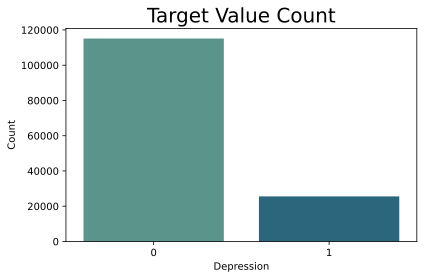

In [21]:
target_counts = train_data[target].value_counts()

plt.figure(figsize=(6,4))
sns.barplot(x=target_counts.index, y=target_counts.values, palette="crest")
plt.ylabel("Count")
plt.title("Target Value Count", fontsize=20)

plt.tight_layout()
plt.show()


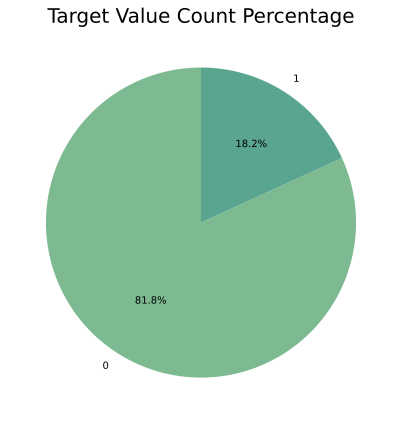

In [22]:
target_counts = train_data[target].value_counts()

plt.figure(figsize=(6,6))
plt.pie(target_counts.values, labels=target_counts.index, autopct='%1.1f%%', startangle=90, colors=sns.color_palette("crest"))
plt.title("Target Value Count Percentage", fontsize=20)

plt.tight_layout()
plt.show()


In [23]:
len(cat_features)


10

In [24]:
n_cols_cat = 2
n_rows_cat = 5


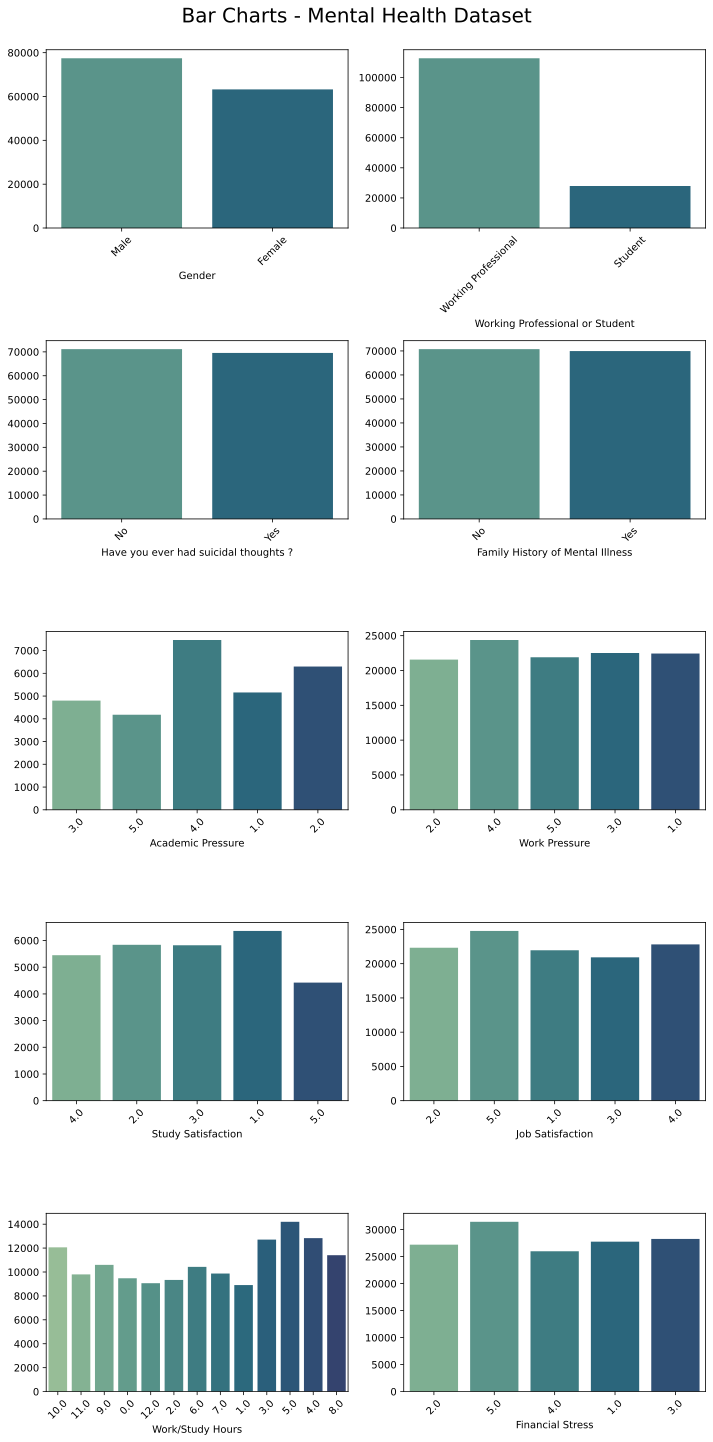

In [25]:
fig, axes = plt.subplots(n_rows_cat, n_cols_cat, figsize=(10, 4*n_rows_cat))
axes = axes.flatten()

for i, column in enumerate(train_data[cat_features].columns):
    ax = axes[i]
    category_counts = train_data[cat_features][column].value_counts()
    sns.barplot(x=category_counts.index, y=category_counts.values, ax=ax, palette="crest")
    ax.set_xticklabels(category_counts.index, rotation=45)

plt.suptitle("Bar Charts - Mental Health Dataset", fontsize=20, y=1.0)

plt.tight_layout()
plt.savefig("Categorical Feature Analysis - Bar Charts.svg")
plt.show()


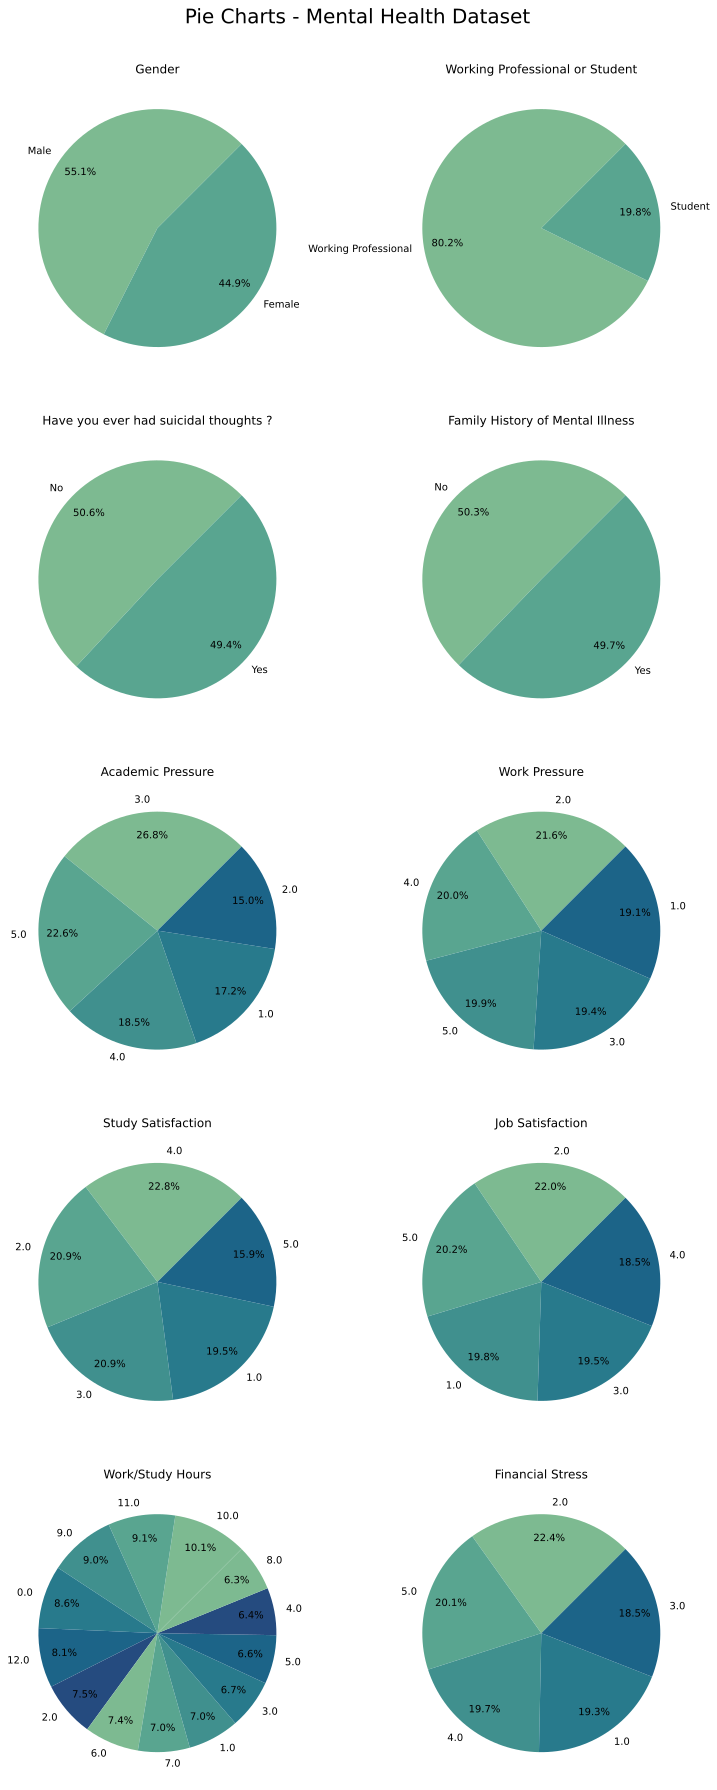

In [26]:
fig, axes = plt.subplots(n_rows_cat, n_cols_cat, figsize=(10, 5*n_rows_cat))
axes = axes.flatten()

for i, column in enumerate(train_data[cat_features].columns):
    ax = axes[i]
    category_counts = train_data[cat_features][column].value_counts()
    ax.pie(
        category_counts.values,
        labels=category_counts.index,
        autopct='%1.1f%%',
        startangle=45,
        colors=sns.color_palette('crest'),
        labeldistance=1.1,
        pctdistance=0.80
    )
    ax.set_title(column)

plt.suptitle('Pie Charts - Mental Health Dataset', fontsize=20, y=1.0)

plt.tight_layout()
plt.savefig("Categorical Feature Analysis - Pie Charts.svg")
plt.show()


In [27]:
len(num_features)


2

In [28]:
n_cols_num = 2
n_rows_num = 1


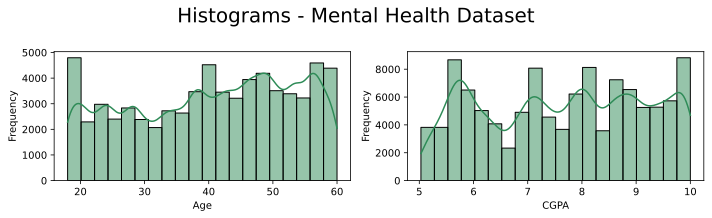

In [29]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

fig, axes = plt.subplots(n_rows_num, n_cols_num, figsize=(10, 3*n_rows_num))
axes = axes.flatten()

for i, col in enumerate(train_data[num_features].columns):
    ax = axes[i]
    sns.histplot(train_data[num_features][col], ax=ax, color='seagreen', stat='frequency', bins=20, kde=True)
    ax.set_ylabel('Frequency')

for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

plt.suptitle('Histograms - Mental Health Dataset', fontsize=20, y=1.0)

plt.tight_layout()
plt.savefig('Numerical Feature Analysis - Histograms.svg')
plt.show()


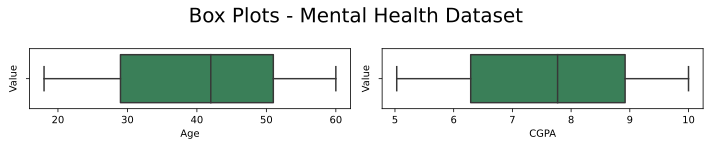

In [30]:
fig, axes = plt.subplots(n_rows_num, n_cols_num, figsize=(10, 2*n_rows_num))
axes = axes.flatten()

for i, col in enumerate(train_data[num_features].columns):
    ax = axes[i]
    sns.boxplot(x=train_data[num_features][col], ax=ax, color='seagreen')
    ax.set_xlabel(col)
    ax.set_ylabel('Value')

for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

plt.suptitle('Box Plots - Mental Health Dataset', fontsize=20, y=1.0)

plt.tight_layout()
plt.savefig('Numerical Feature Analysis - Box Plots.svg')
plt.show()


---

## 1.2.2 Bivariate Analysis

---

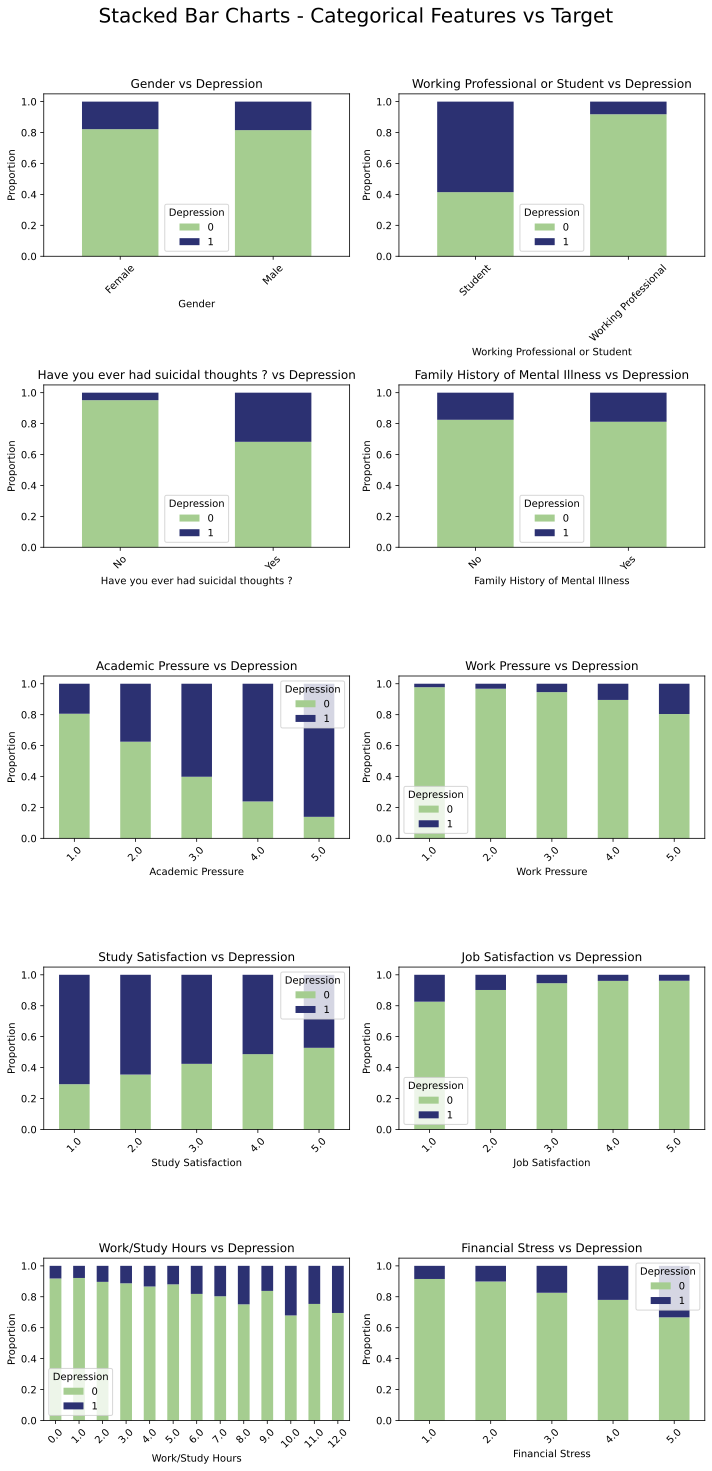

In [31]:
fig, axes = plt.subplots(n_rows_cat, n_cols_cat, figsize=(10, 4*n_rows_cat))
axes = axes.flatten()
colors = sns.color_palette("crest", as_cmap=True)

for i, column in enumerate(train_data[cat_features].columns):
    ax = axes[i]
    cross_tab_data = pd.crosstab(train_data[column], train_data[target], normalize='index')
    cross_tab_data.plot(kind='bar', stacked=True, ax=ax, cmap=colors)
    ax.set_title(f"{column} vs {target}")
    ax.set_xlabel(column)
    ax.set_ylabel("Proportion")
    ax.set_xticklabels(ax.get_xticklabels(), rotation=45)

plt.suptitle("Stacked Bar Charts - Categorical Features vs Target", fontsize=20, y=1.02)

plt.tight_layout()
plt.savefig("Categorical Features vs Target Analysis - Stacked Bar Charts.svg")
plt.show()


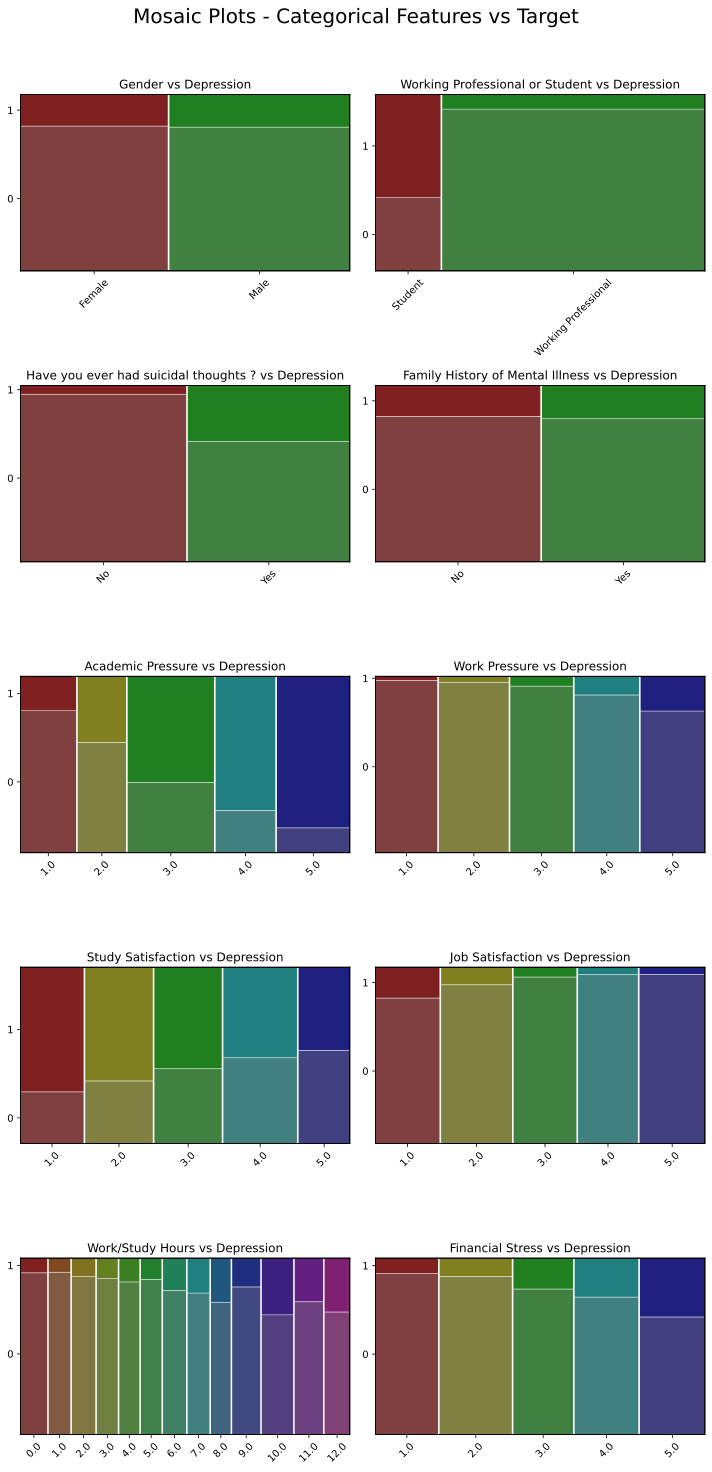

In [32]:
fig, axes = plt.subplots(n_rows_cat, n_cols_cat, figsize=(10, 4*n_rows_cat))
axes = axes.flatten()

for i, column in enumerate(train_data[cat_features].columns):
    ax = axes[i]
    mosaic_data = pd.crosstab(train_data[column], train_data[target]).stack()
    mosaic(mosaic_data, ax=ax, labelizer=lambda k: "")
    ax.set_title(f"{column} vs {target}")
    ax.set_xticklabels(ax.get_xticklabels(), rotation=45)

plt.suptitle("Mosaic Plots - Categorical Features vs Target", fontsize=20, y=1.02)

plt.tight_layout()
plt.savefig("Categorical Features vs Target Analysis - Mosaic Plots.svg")
plt.show()


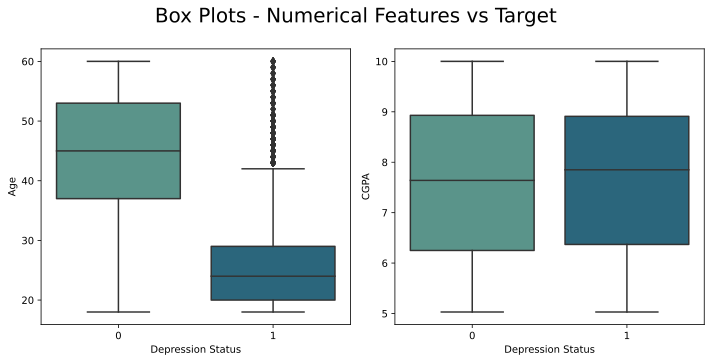

In [33]:
fig, axes = plt.subplots(n_rows_num, n_cols_num, figsize=(10, 5*n_rows_num))
axes = axes.flatten()

for i, col in enumerate(train_data[num_features].columns):
    ax = axes[i]
    sns.boxplot(x=train_data[target], y=train_data[col], ax=ax, palette="crest")
    ax.set_xlabel("Depression Status")
    ax.set_ylabel(col)

for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

plt.suptitle('Box Plots - Numerical Features vs Target', fontsize=20, y=1.0)

plt.tight_layout()
plt.savefig('Numerical Features vs Target Analysis - Box Plots.svg')
plt.show()


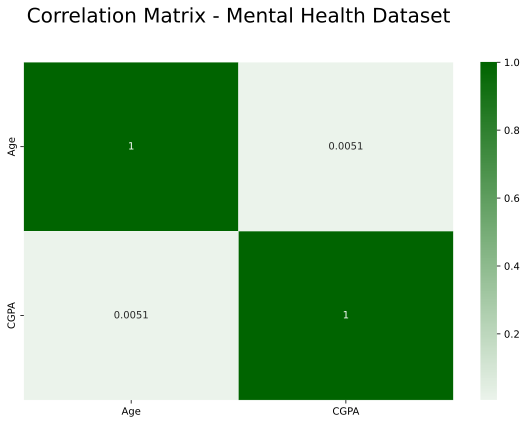

In [34]:
corr = train_data[num_features].corr()
cmap = sns.light_palette("darkgreen", as_cmap=True)

plt.figure(figsize=(8,6))
sns.heatmap(corr, annot=True, cmap=cmap, linewidths=0.2)

plt.title('Correlation Matrix - Mental Health Dataset', fontsize=20, y=1.1)

plt.tight_layout()
plt.savefig('Numerical Features Correlation Analysis - Corr Matrix.svg')
plt.show()


---

# Step 2: Data Preprocessing

---

In [35]:
# Change datatypes for num (float) and (cat features and taregt  - category)

cleaned_features = ['City', 'Profession', 'Sleep Duration', 'Dietary Habits', 'Degree']

for col in cleaned_features:
    train_data[col] = train_data[col].astype('category')

for col in cat_features:
    train_data[col] = train_data[col].astype('category')

for col in num_features:
    train_data[col] = pd.to_numeric(train_data[col])

train_data.dtypes

Gender                                   category
Age                                       float64
City                                     category
Working Professional or Student          category
Profession                               category
Academic Pressure                        category
Work Pressure                            category
CGPA                                      float64
Study Satisfaction                       category
Job Satisfaction                         category
Sleep Duration                           category
Dietary Habits                           category
Degree                                   category
Have you ever had suicidal thoughts ?    category
Work/Study Hours                         category
Financial Stress                         category
Family History of Mental Illness         category
Depression                                  int64
dtype: object

In [36]:
# Clean invalid data

def mark_unknown(df, all_known_values):

    for col in all_known_values:

        if col in df.columns:

            known_values = all_known_values[col]
            df[col] = df[col].apply(lambda x: x if x in known_values else 'unknown')


known_values = {

    'City': [
        'Kalyan', 'Patna', 'Vasai-Virar', 'Kolkata', 'Ahmedabad', 'Meerut',
        'Ludhiana', 'Pune', 'Rajkot', 'Visakhapatnam', 'Srinagar', 'Mumbai',
        'Indore', 'Agra', 'Surat', 'Varanasi', 'Vadodara', 'Hyderabad',
        'Kanpur', 'Jaipur', 'Thane', 'Lucknow', 'Nagpur', 'Bangalore',
        'Chennai', 'Ghaziabad', 'Delhi', 'Bhopal', 'Faridabad', 'Nashik'
        ],

    'Profession': [
        'Teacher', 'Content Writer', 'Architect', 'Consultant', 'HR Manager',
        'Pharmacist', 'Doctor', 'Business Analyst', 'Entrepreneur', 'Chemist',
        'Chef', 'Educational Consultant', 'Data Scientist', 'Researcher',
        'Lawyer', 'Customer Support', 'Marketing Manager', 'Pilot',
        'Travel Consultant', 'Plumber', 'Sales Executive', 'Manager', 'Judge',
        'Electrician', 'Financial Analyst', 'Software Engineer',
        'Civil Engineer', 'UX/UI Designer', 'Digital Marketer', 'Accountant',
        'Mechanical Engineer', 'Graphic Designer', 'Research Analyst',
        'Investment Banker', 'Student', 'Academic','Family Consultant',
        'Analyst', 'Medical Doctor', 'City Manager'
        ],


    'Sleep Duration': [
        'Less than 5 hours', '7-8 hours', 'More than 8 hours', '5-6 hours',
        '3-4 hours', '6-7 hours', '4-5 hours', '2-3 hours', '4-6 hours',
        '6-8 hours', '8-9 hours', '10-11 hours', '9-11 hours', '8 hours',
        '10-6 hours', '9-5', '3-6 hours', 'than 5 hours', '9-6 hours',
        '1-3 hours', '1-2 hours', '9-5 hours'
        ],

    'Dietary Habits': [
        "Moderate", "Unhealthy", "Healthy", "More Healthy",
        "Less Healthy", "Less than Healthy"
        ],

    'Degree': [
        'B.Ed', 'B.Arch', 'B.Com', 'B.Pharm', 'BCA', 'M.Ed', 'MCA', 'BBA',
        'BSc', 'MSc', 'LLM', 'M.Pharm', 'M.Tech', 'B.Tech', 'LLB', 'BHM',
        'MBA', 'BA', 'ME', 'MD', 'MHM', 'BE', 'PhD', 'M.Com', 'MBBS', 'MA',
        'M.Arch', 'B.Sc', 'MTech', 'MPA', 'BPA'
        ]

}

mark_unknown(train_data, known_values)
mark_unknown(test_data, known_values)

In [37]:
cleaned_features = ['City', 'Profession', 'Sleep Duration', 'Dietary Habits', 'Degree']

for col in cleaned_features:
    print("Feature:", col)
    print("Missing Value Count:", train_data[col].isnull().sum())
    print(dict(train_data[col].value_counts()), end='\n\n')



Feature: City
Missing Value Count: 0
{'Kalyan': 6591, 'Patna': 5924, 'Vasai-Virar': 5764, 'Kolkata': 5689, 'Ahmedabad': 5613, 'Meerut': 5527, 'Ludhiana': 5225, 'Pune': 5210, 'Rajkot': 5207, 'Visakhapatnam': 5176, 'Srinagar': 5074, 'Mumbai': 4966, 'Indore': 4872, 'Agra': 4684, 'Surat': 4636, 'Varanasi': 4606, 'Vadodara': 4568, 'Hyderabad': 4496, 'Kanpur': 4398, 'Jaipur': 4328, 'Thane': 4289, 'Lucknow': 4279, 'Nagpur': 4209, 'Bangalore': 4122, 'Chennai': 4044, 'Ghaziabad': 3620, 'Delhi': 3593, 'Bhopal': 3475, 'Faridabad': 3268, 'Nashik': 3144, 'unknown': 98}

Feature: Profession
Missing Value Count: 36625
{'Teacher': 24906, 'Content Writer': 7814, 'Architect': 4370, 'Consultant': 4229, 'HR Manager': 4022, 'Pharmacist': 3893, 'Doctor': 3255, 'Business Analyst': 3161, 'Entrepreneur': 2968, 'Chemist': 2967, 'Chef': 2862, 'Educational Consultant': 2852, 'Data Scientist': 2390, 'Researcher': 2328, 'Lawyer': 2212, 'Customer Support': 2055, 'Marketing Manager': 1976, 'Pilot': 1913, 'Travel Cons

In [38]:
cat_features = cat_features + cleaned_features

preprocessor = ColumnTransformer(
    transformers=[
        ('numerical', Pipeline(steps=[
            ('imputer', SimpleImputer(strategy='median')),
            ('scaler', StandardScaler())
        ]), num_features),

        ('categorical', Pipeline(steps=[
            ('imputer', SimpleImputer(strategy='most_frequent')),
            ('encoder', OneHotEncoder(drop='first', handle_unknown='ignore')),
        ]), cat_features)
    ],
    remainder='passthrough'
)

preprocessor


ColumnTransformer(remainder='passthrough',
                  transformers=[('numerical',
                                 Pipeline(steps=[('imputer',
                                                  SimpleImputer(strategy='median')),
                                                 ('scaler', StandardScaler())]),
                                 ['Age', 'CGPA']),
                                ('categorical',
                                 Pipeline(steps=[('imputer',
                                                  SimpleImputer(strategy='most_frequent')),
                                                 ('encoder',
                                                  OneHotEncoder(drop='first',
                                                                handle_unknown='ignore'))]),
                                 ['Gender', 'Working Professional or Student',
                                  'Have you ever had suicidal thoughts ?',
                                  'Family History of Mental Illness',
                                  'Academic Pressure', 'Work Pressure',
                                  'Study Satisfaction', 'Job Satisfaction',
                                  'Work/Study Hours', 'Financial Stress',
                                  'City', 'Profession', 'Sleep Duration',
                                  'Dietary Habits', 'Degree'])])

In [39]:
X = train_data.drop(columns=target)
y = train_data[target]
X.shape, y.shape

((140695, 17), (140695,))

In [40]:
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.3, random_state=RSEED)


---

# Step 3: Model Training & Evaluation

---

In [41]:
# models = {
#     'XGBoost': XGBClassifier(random_state=RSEED),    # 0.9382
#     'LGBM': LGBMClassifier(random_state=RSEED),   # 0.9388
#     'CatBoost': CatBoostClassifier(random_state=RSEED)    # 0.9387
# }

In [42]:
# def train_models(X_train, X_val, y_train, y_val, models, preprocessor):
#     results = {}
#     pipelines = {}
    
#     for name, model in models.items():
#         pipeline = make_pipeline(preprocessor, model)

#         pipeline.fit(X_train, y_train)
    
#         y_pred = pipeline.predict(X_val)
        
#         score = accuracy_score(y_val, y_pred)
#         print(model, score)
        
#         results[name] = score
#         pipelines[name] = pipeline
                
#     return pipelines, results


# pipelines, scores = train_models(X_train, X_val, y_train, y_val, models, preprocessor)

In [43]:
# scores

In [44]:
# pipelines

In [45]:

# def objective(trial, X_train, X_val, y_train, y_val, preprocessor):
    
#     param = {
#         'objective': 'binary:logistic',
#         'eval_metric': 'logloss',
#         'tree_method': 'hist',
#         'lambda': trial.suggest_loguniform('lambda', 1e-8, 1.0),
#         'alpha': trial.suggest_loguniform('alpha', 1e-8, 1.0),
#         'max_depth': trial.suggest_int('max_depth', 3, 15),
#         'subsample': trial.suggest_uniform('subsample', 0.5, 1.0),
#         'colsample_bytree': trial.suggest_uniform('colsample_bytree', 0.5, 1.0),
#         'min_child_weight': trial.suggest_int('min_child_weight', 1, 10),
#         'learning_rate': trial.suggest_loguniform('learning_rate', 1e-4, 0.1),
#         'n_estimators': 200,
#         'seed': 42,
#         'n_jobs': -1
#     }
    
#     model = XGBClassifier(**param, verbose=2)
#     pipeline = make_pipeline(preprocessor, model)
#     pipeline.fit(X_train, y_train)
    
#     y_pred = pipeline.predict(X_val)
#     score = accuracy_score(y_val, y_pred)
    
#     return score


# def tune_xgb(X_train, X_val, y_train, y_val, preprocessor, n_trials=10):
#     study = optuna.create_study(direction='maximize')
#     study.optimize(lambda trial: objective(trial, X_train, X_val, y_train, y_val, preprocessor), n_trials=n_trials)
    
#     print(f'Best trial: {study.best_trial.params}')

#     best_model = XGBClassifier(**study.best_trial.params)
#     return best_model


# best_xgb_model = tune_xgb(X_train, X_val, y_train, y_val, preprocessor)
# best_xgb_model

In [46]:
# best_model_params = {
#     'lambda': 2.263864375260011e-05, 
#     'alpha': 1.3759394561878038e-07, 
#     'max_depth': 5, 
#     'subsample': 0.7468820497667468, 
#     'colsample_bytree': 0.631459530138708, 
#     'min_child_weight': 2, 
#     'learning_rate': 0.08194831257239564
# }

# best_model = XGBClassifier(**best_model_params)

# best_xgboost_model = make_pipeline(preprocessor, best_model)
# best_xgboost_model.fit(X_train, y_train)

# y_pred = best_xgboost_model.predict(X_val)
# score = accuracy_score(y_val, y_pred)
# print(score)


In [47]:
# def objective(trial, X_train, X_val, y_train, y_val, preprocessor):
    
#     param = {
#         'objective': 'Logloss',
#         'eval_metric': 'Accuracy',
#         'max_depth': trial.suggest_int('max_depth', 3, 15),
#         'subsample': trial.suggest_uniform('subsample', 0.5, 1.0),
#         'colsample_bylevel': trial.suggest_uniform('colsample_bylevel', 0.5, 1.0),
#         'min_child_samples': trial.suggest_int('min_child_samples', 1, 10),
#         'learning_rate': trial.suggest_loguniform('learning_rate', 1e-4, 0.1),
#         'n_estimators': 400,
#         'random_state': 42,
#         'thread_count': -1
#     }
    
#     model = CatBoostClassifier(**param)
#     pipeline = make_pipeline(preprocessor, model)
#     pipeline.fit(X_train, y_train)
    
#     y_pred = pipeline.predict(X_val)
#     score = accuracy_score(y_val, y_pred)
    
#     return score


# def tune_catboost(X_train, X_val, y_train, y_val, preprocessor, n_trials=30):
#     study = optuna.create_study(direction='maximize')
#     study.optimize(lambda trial: objective(trial, X_train, X_val, y_train, y_val, preprocessor), n_trials=n_trials)
    
#     print(f'Best trial: {study.best_trial.params}')

#     best_model_params = study.best_trial.params

#     return best_model_params


# best_model_params = tune_catboost(X_train, X_val, y_train, y_val, preprocessor)
# best_model_params

In [48]:
best_model_params = {
    'objective': 'Logloss',
    'eval_metric': 'Accuracy',
    'max_depth': 10,
    'subsample': 0.7393053035420207,
    'colsample_bylevel': 0.7283252490351774,
    'min_child_samples': 10,
    'learning_rate': 0.04847794745649587,
    'n_estimators': 300,
    'random_state': 42
}

best_model = CatBoostClassifier(**best_model_params)

best_catboost_model = make_pipeline(preprocessor, best_model)
best_catboost_model.fit(X_train, y_train)

y_pred = best_catboost_model.predict(X_val)
score = accuracy_score(y_val, y_pred)
score


0:	learn: 0.9179680	total: 89.5ms	remaining: 26.8s
1:	learn: 0.9246086	total: 126ms	remaining: 18.8s
2:	learn: 0.9271064	total: 163ms	remaining: 16.1s
3:	learn: 0.9268932	total: 201ms	remaining: 14.8s
4:	learn: 0.9282741	total: 237ms	remaining: 14s
5:	learn: 0.9268627	total: 253ms	remaining: 12.4s
6:	learn: 0.9260504	total: 290ms	remaining: 12.1s
7:	learn: 0.9274110	total: 326ms	remaining: 11.9s
8:	learn: 0.9280405	total: 363ms	remaining: 11.8s
9:	learn: 0.9276445	total: 400ms	remaining: 11.6s
10:	learn: 0.9278882	total: 436ms	remaining: 11.5s
11:	learn: 0.9275532	total: 475ms	remaining: 11.4s
12:	learn: 0.9280608	total: 512ms	remaining: 11.3s
13:	learn: 0.9286396	total: 550ms	remaining: 11.2s
14:	learn: 0.9286904	total: 586ms	remaining: 11.1s
15:	learn: 0.9289544	total: 622ms	remaining: 11s
16:	learn: 0.9294417	total: 657ms	remaining: 10.9s
17:	learn: 0.9298581	total: 692ms	remaining: 10.8s
18:	learn: 0.9302337	total: 729ms	remaining: 10.8s
19:	learn: 0.9301728	total: 767ms	remaining:

/opt/conda/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:202: UserWarning: Found unknown categories in columns [12, 14] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


0.9389940534009334

---

# Step 4: Test Data Prediction

---

In [49]:
test_data_predictions = best_catboost_model.predict(test_data)
test_data_predictions

/opt/conda/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:202: UserWarning: Found unknown categories in columns [12] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


array([0, 0, 0, ..., 0, 1, 0])

In [50]:
submission = pd.read_csv('/kaggle/input/playground-series-s4e11/sample_submission.csv')
submission[target] = test_data_predictions

submission.to_csv('submission.csv', index=False)
submission.head()


,id,Depression
0,140700,0
1,140701,0
2,140702,0
3,140703,1
4,140704,0
